In [1]:
"""
Figure 2 InputDSA Data Analysis 
"""
%load_ext autoreload
%autoreload 2

# SHARED PARAMETERS - used consistently across all analyses below
# Only change these values to modify the entire notebook behavior
n = 10          # latent state dim
n_large = 50
m = 1           # input dim  
p_out = 10      # observed dim (partial observation) - gets overridden in some cells
p_out_small = 2
N = 10000        # sequence length
N_small = 1000
n_Us = 4
obs_noise = 0.0001
process_noise = 0.0#1
nonlinear_eps = 0.01
input_alpha = 0.001
g1 = 1
g2 = 1.5
rho1 = 0.92
rho2 = 0.82
seed1 = 11
seed2 = 12
n_delays = 150
rank = 10
pf = 150
n_iters = 10
backend = 'n4sid'

print(f"Shared parameters:")
print(f"  System: n={n}, m={m}, p_out={p_out}, N={N}")
print(f"  Dynamics: rho1={rho1}, rho2={rho2}, g1={g1}, g2={g2}")
print(f"  Noise: obs_noise={obs_noise}, process_noise={process_noise}")
print(f"  Nonlinearity: nonlinear_eps={nonlinear_eps}")
print(f"  Model: n_delays={n_delays}, rank={rank}, pf={pf}")
print(f"  Evaluation: n_iters={n_iters}")


Shared parameters:
  System: n=10, m=1, p_out=10, N=10000
  Dynamics: rho1=0.92, rho2=0.82, g1=1, g2=1.5
  Noise: obs_noise=0.0001, process_noise=0.0
  Nonlinearity: nonlinear_eps=0.01
  Model: n_delays=150, rank=10, pf=150
  Evaluation: n_iters=10


In [2]:
# in this analysis, we are goign to look at how to appropriately compare partially observed systems
# we will look at the following systems

# 4 systems, made up fo 2 pairings (1,2) (3,4) same intrinsic dynamics, (1,3) (2,4) same read in dynamics
# we will look at the behavior in the fully observed setting of DSA and AgentDSA, and then in the
#partially observed setting of DMDc versus subspace DMDc
#we'll looking at clustering capability across many instantiatons of the data, 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Updated to use DSA package imports
import sys
sys.path.insert(0, '..')  # Add parent directory to path to import DSA

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [3]:
from DSA import InputDSA
from DSA import SimilarityTransformDist as SimDist
from DSA import ControllabilitySimilarityTransformDist as ControlSimDist
from tqdm import tqdm

def compare_systems_with_InputDSA(Ys, Us, n_delays=150, rank=10, backend='n4sid'):
    """
    Compare controlled systems using InputDSA from DSA package.
    Uses the new update_compare_method() to avoid refitting DMDs multiple times.
    
    Parameters:
    - Ys: list of output data arrays (p_out, N)
    - Us: list of control input arrays (m, N)
    - n_delays: number of delays for DMD
    - rank: rank for DMD
    - backend: 'n4sid' or 'custom' for SubspaceDMDc
    
    Returns:
    - sims_full: joint similarity scores
    - sims_control_joint: control scores from joint optimization
    - sims_state_joint: state scores from joint optimization
    - sims_control_separate: control scores from separate optimization
    - sims_state_separate: state scores from separate optimization
    """
    # Transpose data for InputDSA (expects time_first=True by default)
    Ys_T = [Y.T for Y in Ys]
    Us_T = [U.T for U in Us]
    
    # Configure DMD
    # dmd_config = SubspaceDMDcConfig(
        # n_delays=n_delays,
        # rank=rank,
        # backend=backend
    # )
    dmd_config = dict(
        n_delays=n_delays,
        rank=rank,
        backend=backend
    )
    
    # Create InputDSA with joint comparison
    # This will fit the DMDs once and return joint comparison results
    inputDSA = InputDSA(
        X=Ys_T,
        X_control=Us_T,
        dmd_config=dmd_config,
        compare='joint',
        return_distance_components=True
    )
    
    # Fit DMDs and get joint comparison results
    sims_full, sims_state_joint, sims_control_joint = inputDSA.fit_score()
    
    # Update comparison method to 'state' without refitting DMDs
    inputDSA.update_compare_method(compare='state')
    sims_state_separate = inputDSA.score()
    
    # Update comparison method to 'control' without refitting DMDs
    inputDSA.update_compare_method(compare='control')
    sims_control_separate = inputDSA.score()
    
    return sims_full, sims_control_joint, sims_state_joint, sims_control_separate, sims_state_separate


#strict comparison metrics, for when we fit and compare separately
def compare_A(A1,A2):
    simdist = SimDist(iters=1000,score_method='wasserstein',lr=1e-3,verbose=True)
    return simdist.fit_score(A1,A2)

def compare_A_full(As):
    sims = np.zeros((len(As),len(As)))
    for i in range(len(As)):
        for j in range(i+1,len(As)):
            sims[i,j] = compare_A(As[i],As[j])
            sims[j,i] = sims[i,j]
    return sims

def compare_B(B1,B2):
    csimdist = ControlSimDist(score_method='euclidean',compare='control')
    sim = csimdist.fit_score(None, None, B1, B2)
    return sim

def compare_systems_full(As,Bs):
    csimdist = ControlSimDist(score_method='euclidean',compare='joint',return_distance_components=True)
    sims_full = np.zeros((len(As),len(As)))
    sims_control_joint = np.zeros((len(As),len(As)))
    sims_state_joint = np.zeros((len(As),len(As)))
    sims_control_separate = np.zeros((len(As),len(As)))
    sims_state_separate = np.zeros((len(As),len(As)))
    for i in tqdm(range(len(As))):
        for j in range(i+1,len(As)):
            all_sims = csimdist.fit_score(As[i],As[j],Bs[i],Bs[j])
            sims_full[i,j] = sims_full[j,i] = all_sims[0]
            sims_state_joint[i,j] = sims_state_joint[j,i] = all_sims[1]
            sims_control_joint[i,j] = sims_control_joint[j,i] = all_sims[2]
 
    for i in tqdm(range(len(As))):
        for j in range(i+1,len(As)):
            sims_state_separate[i,j] = compare_A(As[i],As[j])
            sims_control_separate[i,j] = compare_B(Bs[i],Bs[j])
            sims_state_separate[j,i] = sims_state_separate[i,j]
            sims_control_separate[j,i] = sims_control_separate[i,j]

    return sims_full, sims_control_joint, sims_state_joint, sims_control_separate, sims_state_separate



In [4]:
def make_stable_A(n, rho=0.9, rng=None):
    rng = np.random.default_rng(rng)
    M = rng.standard_normal((n, n))
    # Make it diagonally dominant-ish and scale spectral radius
    A = M / np.max(np.abs(np.linalg.eigvals(M))) * rho
    return A

def simulate_system(A, B, C, U, x0=None,rng=None,obs_noise=0.0,process_noise=0.0,
    nonlinear_eps=0.0,nonlinear_func= lambda x: np.tanh(x),nonlinear_eps_input=0.0):
    n, m = B.shape
    p_out = C.shape[0]
    N = U.shape[1]
    X = np.zeros((n, N+1))
    C_full = np.eye(A.shape[0])
    C_full[np.where(C == 1)[1],np.where(C == 1)[1]] = 0.0

    if x0 is not None:
        X[:, 0] = x0
    else:
        X[:, 0] = np.random.default_rng(rng).standard_normal((n,))
    Y = np.zeros((p_out, N))
    for t in range(N):
        X[:, t+1] = A @ (X[:, t]) + nonlinear_eps * C_full @ nonlinear_func(A @ X[:, t]) + \
            B @ ((1-nonlinear_eps_input) * U[:, t] + nonlinear_eps_input * nonlinear_func(U[:, t])) + \
                np.random.normal(0, process_noise, (n,))
        Y[:, t] = C @ X[:, t] + np.random.normal(0, obs_noise, (p_out,))
    return X[:, 1:], Y  # states aligned with Y

def smooth_input(m, N, alpha=0.9, rng=None):
    rng = np.random.default_rng(rng)
    w = rng.standard_normal((m, N))
    U = np.zeros_like(w)
    for t in range(N):
        U[:, t] = alpha*(U[:, t-1] if t>0 else 0) + (1-alpha)*w[:, t]
    return U

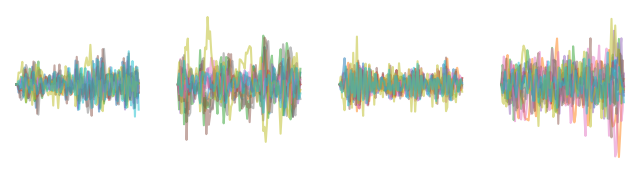

In [5]:
def simulate_As_Bs(latent_dim, input_dim, observed_dim, seq_length,rho1=rho1,
    rho2=rho2, g1=g1,g2=g2, seed1=seed1, seed2=seed2, input_alpha=input_alpha,same_inp=False,n_Us=n_Us,
    obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps,nonlinear_func= lambda x: np.tanh(x)):

    A1_true = make_stable_A(latent_dim, rho=rho1, rng=seed1)
    cov_matrix_B1 = np.random.default_rng(seed1).standard_normal((latent_dim, latent_dim))
    cov_matrix_B1 = cov_matrix_B1 @ cov_matrix_B1.T  # Make it symmetric positive definite
    B1_true = np.random.default_rng(seed1).multivariate_normal(np.zeros(latent_dim), cov_matrix_B1, input_dim).T * g1

    A2_true = make_stable_A(latent_dim, rho=rho2, rng=seed2)
    C = np.linalg.qr(np.random.default_rng(seed2).standard_normal((latent_dim, latent_dim)))[0]
    cov_matrix_B2_rotated = C @ cov_matrix_B1 @ C.T  
    B2_true = np.random.default_rng(seed2).multivariate_normal(np.zeros(latent_dim), cov_matrix_B2_rotated, input_dim).T * g2

    # Random partial observation: select p_out of n states
    idx_obs = np.sort(np.random.default_rng(seed1).choice(latent_dim, size=observed_dim, replace=False))
    C_true = np.zeros((observed_dim, latent_dim))
    C_true[np.arange(observed_dim), idx_obs] = 1.0
  
    X_trues, Ys,Us = [], [], []
    i = 0
    if same_inp:
        U = smooth_input(input_dim, seq_length, alpha=input_alpha, rng=seed1+i) 
    control_labels = []
    state_labels = []
    for a1, As in enumerate([A1_true, A2_true]):
        for b1, Bs in enumerate([B1_true, B2_true]):
            i += 1
            if not same_inp:
                for j in range(n_Us):
                    U = smooth_input(input_dim, seq_length, alpha=input_alpha, rng=seed1+ i + j) 
                    X_true, Y = simulate_system(As, Bs, C_true, U, x0=np.zeros(latent_dim),rng=seed1+i,
                        obs_noise=obs_noise,process_noise=process_noise,
                        nonlinear_eps=nonlinear_eps,nonlinear_func=nonlinear_func)
                    X_trues.append(X_true)
                    Ys.append(Y)
                    Us.append(U)
                    control_labels.append(b1)
                    state_labels.append(a1)
            else:
                X_true, Y = simulate_system(As, Bs, C_true, U, x0=np.zeros(latent_dim),rng=seed1+i,
                    obs_noise=obs_noise,process_noise=process_noise,
                    nonlinear_eps=nonlinear_eps,nonlinear_func=nonlinear_func)
                X_trues.append(X_true)
                Ys.append(Y)
                Us.append(U)
                control_labels.append(b1)
                state_labels.append(a1)

    return X_trues, Ys, Us, control_labels, state_labels, (A1_true, A2_true), (B1_true, B2_true)


X_trues, Ys, Us, control_labels, state_labels, A_trues, B_trues = simulate_As_Bs(n,m,p_out,N,
                                        input_alpha=input_alpha,g1=g1,g2=g2,n_Us=1,obs_noise=obs_noise,process_noise=process_noise,
                                        nonlinear_eps=nonlinear_eps,nonlinear_func= lambda x: np.tanh(x))
fig, ax = plt.subplots(1, 4, figsize=(8, 2),sharey='row')
#plot Us and Ys against time
for i in range(4):
    # ax[0, i].plot(Us[i].T[:100])
    ax[i].plot(Ys[i].T[:100,:],alpha=0.5)
    
    # Remove spines and ticks
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
# plt.savefig(f'{folder_path}/data_examples.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# X_trues, Ys, Us, control_labels, state_labels, A_trues, B_trues = simulate_As_Bs(n,m,p_out,N_small,
#                                         input_alpha=input_alpha,g1=g1,g2=g2, same_inp=False,n_Us=4,
#                                         obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps)


In [6]:
from DSA import DMD,DMDc, SubspaceDMDc
from tqdm import tqdm

def get_dmds(Ys,n_delays=1,rank=None):
    As = []
    for Y in Ys:
        dmd = DMD(Y.T,n_delays=n_delays,rank=rank)
        dmd.fit()
        As.append(dmd.A_v.numpy())
    return As

def get_dmdcs(Ys,Us,n_delays=1,rank=None):
    As = []
    Bs = []
    for Y, U in zip(Ys, Us):
        dmdc = DMDc(Y.T, U.T,n_delays=n_delays,n_control_delays=n_delays,rank_input=rank,rank_output=rank)
        dmdc.fit()
        As.append(dmdc.A_v.numpy())
        Bs.append(dmdc.B_v.numpy())
    return As, Bs


def get_subspace_dmdcs(Ys, Us, p=20, rank=None, backend='n4sid'):
    """Fit SubspaceDMDc models using DSA package."""
    As, Bs, Cs, infos = [], [], [], []
    for Y, U in zip(Ys, Us):
        model = SubspaceDMDc(Y.T, U.T, n_delays=p, rank=rank, backend=backend)
        model.fit()
        As.append(model.A_v)#.numpy())
        Bs.append(model.B_v)#.numpy())
        Cs.append(model.C_v)#.numpy())
        infos.append(model.info)
    return As, Bs, Cs, infos



In [7]:
X_trues, Ys, Us, control_labels, state_labels, A_trues, B_trues = simulate_As_Bs(n,m,p_out_small,
                                    N_small,input_alpha=input_alpha,g1=g1,g2=g2,same_inp=False,n_Us=n_Us,
                                    obs_noise=obs_noise,process_noise=process_noise,
                                    nonlinear_eps=nonlinear_eps)
print([i.shape for i in Ys])

[(2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000)]


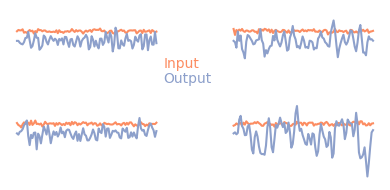

In [8]:
#plot examples of the inputs and the outputs
fig, ax = plt.subplots(2,2,figsize=(4,2),sharex=True,sharey=True)
ax = ax.flatten()
for i in range(4):
    ind = 4*i
    ax[i].plot(Us[ind].T[:100] + 10*np.mean(np.abs(Us[ind])), color=plt.cm.Set2(1), label='Input (u)')
    ax[i].plot(Ys[ind].T[:100, 0], color=plt.cm.Set2(2), label='Output (y)')
    #remove all ticks and lines
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    
ax[0].text(1, 0.4, 'Input', transform=ax[0].transAxes, color=plt.cm.Set2(1), va='top')
ax[0].text(1, 0.2, 'Output', transform=ax[0].transAxes, color=plt.cm.Set2(2), va='top')
plt.tight_layout()
# plt.savefig(f'{folder_path}/input_output_examples.pdf', format='pdf', dpi=300, bbox_inches='tight')



[legend.py:1217 -   _parse_legend_args() ] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


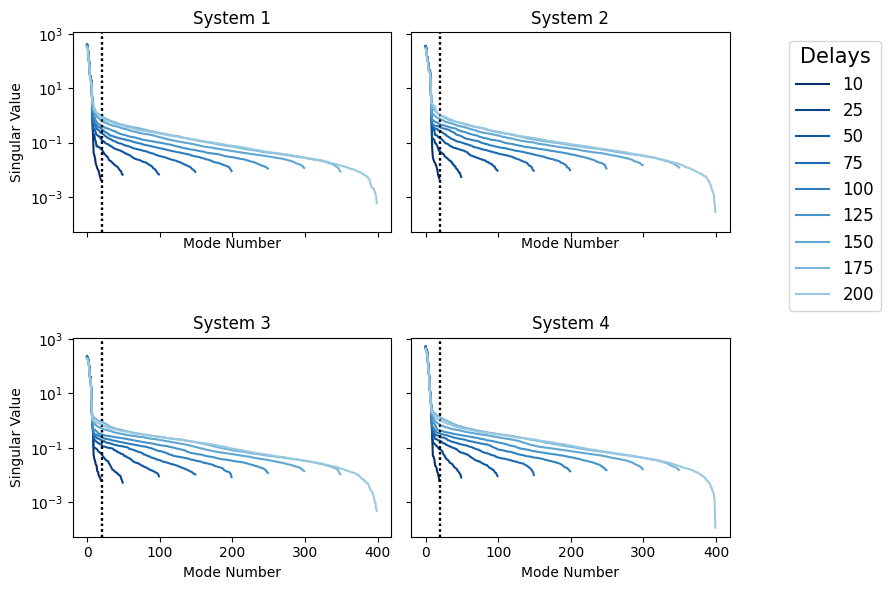

In [9]:
# Use SubspaceDMDc from DSA package to analyze singular values


fig, ax = plt.subplots(2,2,figsize=(9,6),sharey=True,sharex=True)
ax = ax.flatten()
            
for j, (Y, U) in enumerate(zip(Ys[::n_Us], Us[::n_Us])):
    # Test different numbers of delays for subspace identification
    nds_all = [10, 25, 50, 75, 100, 125, 150, 175, 200]
    
    for k, nds in enumerate(nds_all):
        # Fit SubspaceDMDc with varying number of delays
        model = SubspaceDMDc(
            Y.T,  # SubspaceDMDc expects (T, p_out)
            U.T,  # SubspaceDMDc expects (T, m)
            n_delays=nds,
            rank=20,  # Use fixed rank for comparison
            backend='n4sid'
        )
        model.fit()
        
        # Extract singular values from model info
        singular_vals = model.info['singular_values_O']
        
        # Convert to numpy if needed
        if hasattr(singular_vals, 'numpy'):
            singular_vals = singular_vals.numpy()
        
        # Plot singular values
        ax[j].plot(singular_vals, '-', label=f'{nds}', 
                  color=plt.cm.Blues_r(k / (len(nds_all) + 4)))
        ax[j].set_yscale('log')
        ax[j].axvline(x=20, color='k', linestyle=':', alpha=0.5)
    
    ax[j].set_xlabel('Mode Number')
    ax[j].set_title(f'System {j+1}')
    ax[1].legend(title="Delays", loc='upper right', bbox_to_anchor=(1.5, 1), 
                fontsize=12, title_fontsize=15)

ax[0].set_ylabel('Singular Value')
ax[2].set_ylabel('Singular Value')
plt.tight_layout()
# plt.savefig(f'{folder_path}/singular_values_subspace_dmdc.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [10]:
dec = 0 #can change this to look at the efect of using the incorrect ranks
A_dmd = get_dmds(Ys,n_delays=n_delays,rank=rank- dec)
A_cs, B_cs = get_dmdcs(Ys,Us,n_delays=n_delays,rank=rank - dec)
As, Bs, Cs, infos = get_subspace_dmdcs(Ys,Us,p=pf,rank=rank-dec,backend='custom')


Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150
Number of valid trials: 150


N4SID - A matrix shapes: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
N4SID - Ranks used: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
N4SID - Backend info: ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
\nEigenvalue comparison (first system):


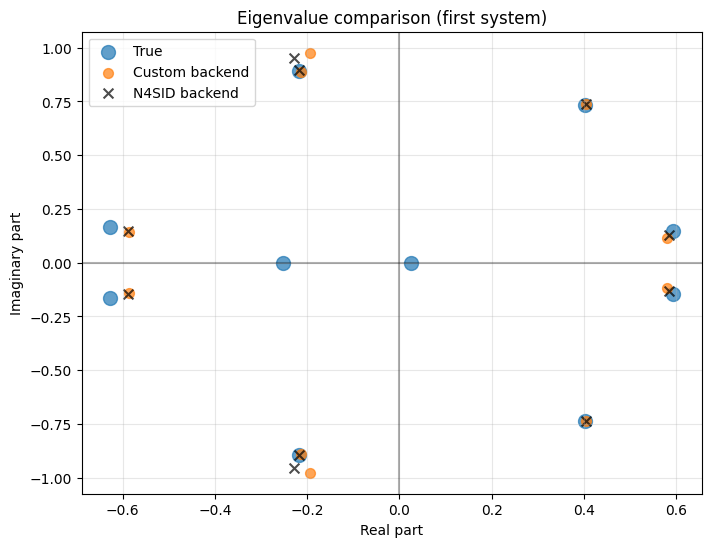

\nComputing similarity matrices...


100%|██████████| 16/16 [00:00<00:00, 135.77it/s]

Custom backend silhouette score: 0.685
N4SID backend silhouette score: 0.669


In [11]:
As_n4sid, Bs_n4sid, Cs_n4sid, infos_n4sid = get_subspace_dmdcs(Ys, Us, p=pf, rank=rank-dec, backend='n4sid')
print(f"N4SID - A matrix shapes: {[A.shape for A in As_n4sid]}")
print(f"N4SID - Ranks used: {[info['rank_used'] for info in infos_n4sid]}")
print(f"N4SID - Backend info: {[info.get('backend', 'unknown') for info in infos_n4sid]}")

# Quick comparison of eigenvalues (first system)
print("\\nEigenvalue comparison (first system):")
eigs_custom = np.linalg.eigvals(As[0])
eigs_n4sid = np.linalg.eigvals(As_n4sid[0])
eigs_real = np.linalg.eigvals(A_trues[0])

plt.figure(figsize=(8, 6))
plt.scatter(eigs_real.real, eigs_real.imag, alpha=0.7, label='True', s=100)
plt.scatter(eigs_custom.real, eigs_custom.imag, alpha=0.7, label='Custom backend', s=50)
plt.scatter(eigs_n4sid.real, eigs_n4sid.imag, alpha=0.7, label='N4SID backend', s=50, marker='x',c='k')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Eigenvalue comparison (first system)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.show()

# Compute distances using both backends for comparison
print("\\nComputing similarity matrices...")
_, _, _, _, sims_state_custom = compare_systems_full(As, Bs)
_, _, _, _, sims_state_n4sid = compare_systems_full(As_n4sid, Bs_n4sid)

from sklearn.metrics import silhouette_score
silh_custom = silhouette_score(sims_state_custom, state_labels, metric='precomputed')
silh_n4sid = silhouette_score(sims_state_n4sid, state_labels, metric='precomputed')


print(f"Custom backend silhouette score: {silh_custom:.3f}")
print(f"N4SID backend silhouette score: {silh_n4sid:.3f}")

100%|██████████| 16/16 [00:00<00:00, 135.16it/s]


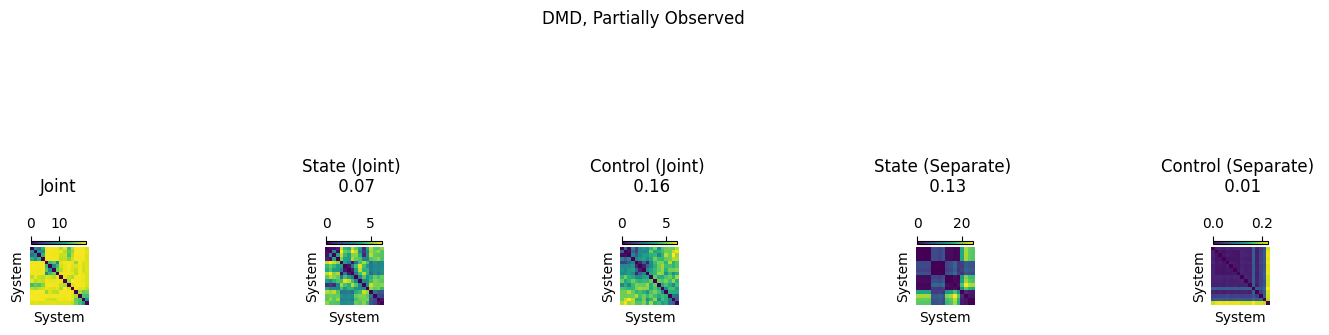

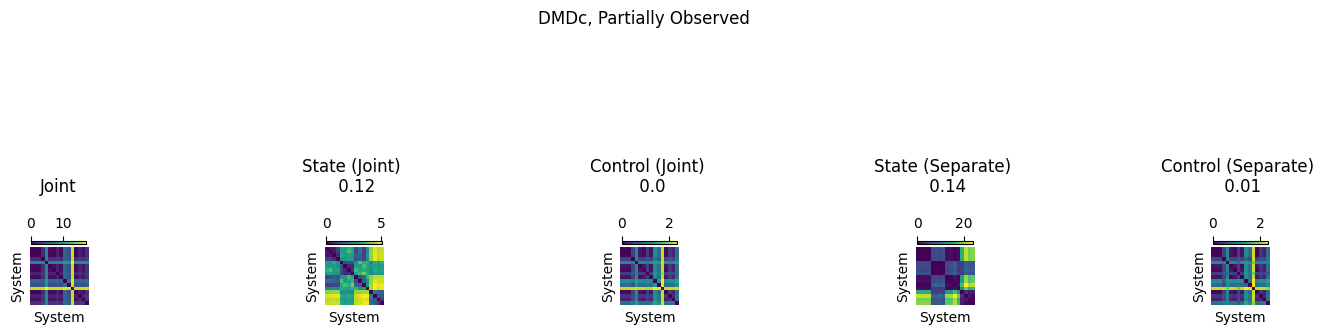

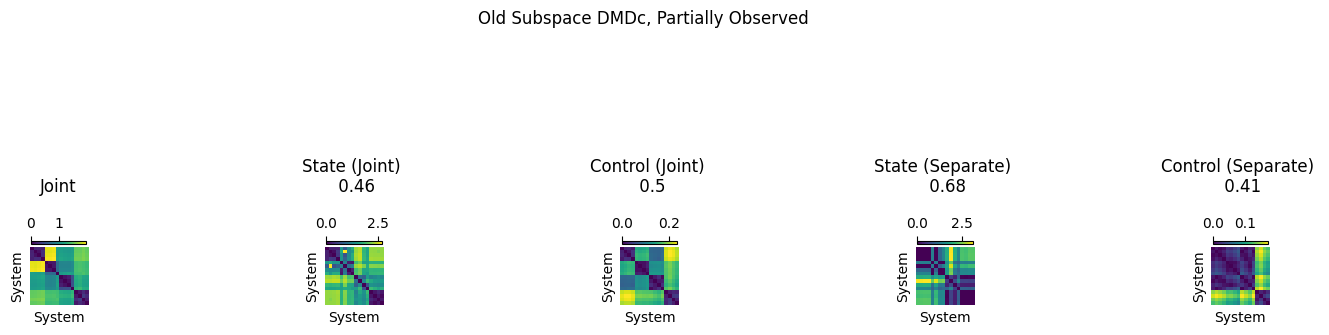

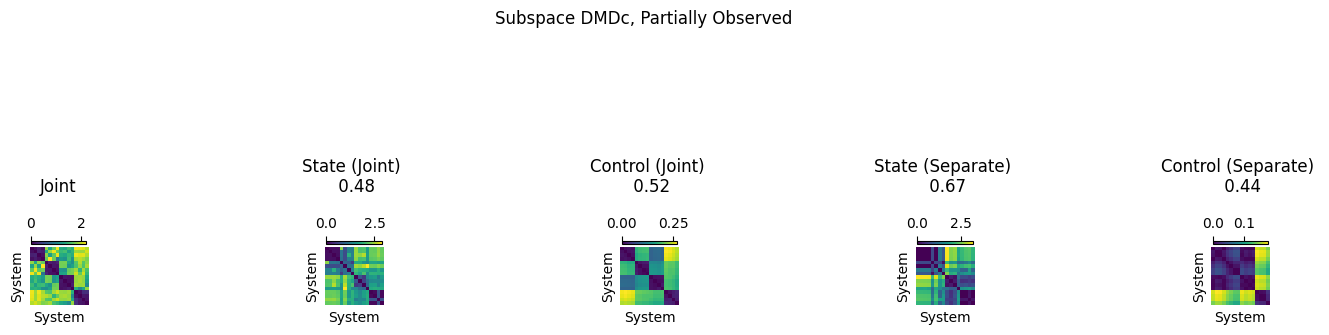

In [12]:
from sklearn.metrics import silhouette_score
A_type = [A_dmd, A_cs, As, As_n4sid]
B_type = [A_dmd, B_cs, Bs, Bs_n4sid]
names = ['DMD, Partially Observed', 'DMDc, Partially Observed', 'Old Subspace DMDc, Partially Observed', 'Subspace DMDc, Partially Observed']
for Ai, Bi, name in zip(A_type, B_type, names):

    sims_full, sims_control_joint, sims_state_joint, sims_control_separate, sims_state_separate = compare_systems_full(Ai,Bi)

    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    
    # Define data and titles for each subplot
    sims_data = [sims_full, sims_state_joint, sims_control_joint, sims_state_separate, sims_control_separate]
    titles = ['Joint', 
              f'State (Joint) \n {np.round(silhouette_score(sims_state_joint,state_labels,metric="precomputed"),2)}',
              f'Control (Joint) \n {np.round(silhouette_score(sims_control_joint,control_labels,metric="precomputed"),2)}',
              f'State (Separate) \n {np.round(silhouette_score(sims_state_separate,state_labels,metric="precomputed"),2)}',
              f'Control (Separate) \n {np.round(silhouette_score(sims_control_separate,control_labels,metric="precomputed"),2)}']
    
    # Loop through all subplots
    for i, (data, title) in enumerate(zip(sims_data, titles)):
        im = ax[i].imshow(data)
        cbar = plt.colorbar(im, ax=ax[i], shrink=0.2, location='top')#, label='Distance')
        cbar.ax.tick_params(labelsize=10)
        cbar.ax.spines['top'].set_visible(False)
        cbar.ax.spines['right'].set_visible(False)
        cbar.ax.spines['bottom'].set_visible(False)
        cbar.ax.spines['left'].set_visible(False)
        ax[i].set_title(title,y=1.8)
    #loop through all of them and remove x and yticks, then add System as text label for each
    for i in range(5):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        # ax[i].text(0.5, -0.1, 'System', transform=ax[i].transAxes, ha='center', va='top')
        ax[i].set_ylabel('System')
        ax[i].set_xlabel('System')
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    plt.suptitle(name,y=1.1)
    plt.tight_layout()
    # plt.savefig(f'{folder_path}/{name}.eps', format='eps', dpi=300, bbox_inches='tight')


100%|██████████| 16/16 [00:00<00:00, 95.83it/s]


Silhouette Scores:
DMD State: 0.132
DMDc State: 0.143
DMDc Control: 0.002
SubspaceDMDc State: 0.669
SubspaceDMDc Control: 0.521


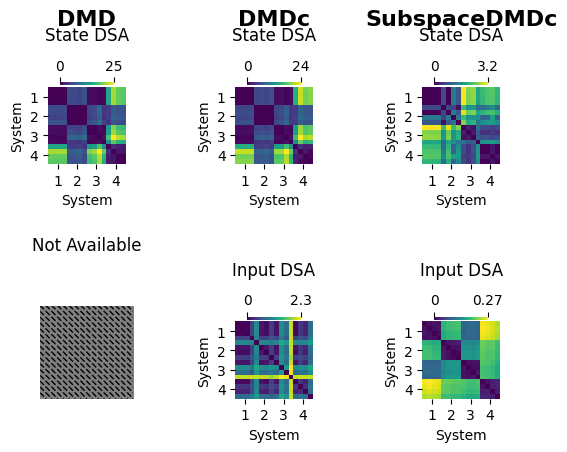

In [13]:
# Get the similarity matrices for each method
sims_full_dmd, sims_control_joint_dmd, sims_state_joint_dmd, sims_control_separate_dmd, sims_state_separate_dmd = compare_systems_full(A_dmd, A_dmd)
sims_full_dmdc, sims_control_joint_dmdc, sims_state_joint_dmdc, sims_control_separate_dmdc, sims_state_separate_dmdc = compare_systems_full(A_cs, B_cs)
sims_full_subdmdc, sims_control_joint_subdmdc, sims_state_joint_subdmdc, sims_control_separate_subdmdc, sims_state_separate_subdmdc = compare_systems_full(As_n4sid, Bs_n4sid)

# Print silhouette scores
print("Silhouette Scores:")
print(f"DMD State: {np.round(silhouette_score(sims_state_separate_dmd, state_labels, metric='precomputed'), 3)}")
print(f"DMDc State: {np.round(silhouette_score(sims_state_separate_dmdc, state_labels, metric='precomputed'), 3)}")
print(f"DMDc Control: {np.round(silhouette_score(sims_control_joint_dmdc, control_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc State: {np.round(silhouette_score(sims_state_separate_subdmdc, state_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc Control: {np.round(silhouette_score(sims_control_joint_subdmdc, control_labels, metric='precomputed'), 3)}")

# Create 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(6, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Column headers (bold)
column_headers = ['DMD', 'DMDc', 'SubspaceDMDc']
for i, header in enumerate(column_headers):
    axes[0, i].text(0.5, 1.75, header, transform=axes[0, i].transAxes, ha='center', va='bottom', fontweight='bold', fontsize=16)

# Row headers
row_headers = ['State DSA', ['Not Available', 'Input DSA', 'Input DSA']]
for i in range(3):
    axes[0, i].text(0.5, 1.55, 'State DSA', transform=axes[0, i].transAxes, ha='center', va='bottom', fontsize=12)

axes[1, 0].text(0.5, 1.55, 'Not Available', transform=axes[1, 0].transAxes, ha='center', va='bottom', fontsize=12)
axes[1, 1].text(0.5, 1.55, 'Input DSA', transform=axes[1, 1].transAxes, ha='center', va='bottom', fontsize=12)
axes[1, 2].text(0.5, 1.55, 'Input DSA', transform=axes[1, 2].transAxes, ha='center', va='bottom', fontsize=12)

# Data for each subplot
data_matrices = [
    sims_state_separate_dmd,    # top left
    sims_state_separate_dmdc,   # top middle  
    sims_state_separate_subdmdc, # top right
    None,                       # bottom left (gray matrix)
    sims_control_joint_dmdc,    # bottom middle
    sims_control_joint_subdmdc  # bottom right
]

# Create gray matrix for bottom left - use same size as other matrices
matrix_size = sims_state_separate_dmd.shape[0]
gray_matrix = np.ones((matrix_size, matrix_size)) * 0.5

# Plot each subplot
for idx, (ax, data) in enumerate(zip(axes.flat, data_matrices)):
    row = idx // 3
    col = idx % 3
    
    if idx == 3:  # Bottom left - gray matrix with diagonal lines
        im = ax.imshow(gray_matrix, cmap='gray', vmin=0, vmax=1, extent=[-0.5, matrix_size-0.5, matrix_size-0.5, -0.5])
        
        # Add diagonal lines from bottom-left to top-right
        for i in range(matrix_size):
            for j in range(matrix_size):
                ax.plot([j-0.5, j+0.5], [i-0.5, i+0.5], 'k--', linewidth=1)
        
        # Set axis limits to match other plots
        ax.set_xlim(-0.5, matrix_size-0.5)
        ax.set_ylim(matrix_size-0.5, -0.5)
        
        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Remove spines
        for spine in ax.spines.values():
            spine.set_visible(False)
        
    else:
        im = ax.imshow(data, cmap='viridis')
        
        # Add colorbar on top with only 2 ticks
        cbar = plt.colorbar(im, ax=ax, shrink=0.4, location='top', pad=0.02)
        vmin, vmax = data.min(), data.max()
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([f'{vmin:.2g}', f'{vmax:.2g}'])
        cbar.ax.tick_params(labelsize=10)
        
        # Remove colorbar spines
        for spine in cbar.ax.spines.values():
            spine.set_visible(False)
        
        # Set custom tick positions and labels (every 4 positions)
        tick_positions = [1.5, 5.5, 9.5, 13.5]  # Middle of each group of 4
        tick_labels = ['1', '2', '3', '4']
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels,fontsize=10)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels,fontsize=10)
        
        # Set axis labels
        ax.set_xlabel('System',fontsize=10)
        ax.set_ylabel('System',fontsize=10)
        
        # Remove spines
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()


100%|██████████| 16/16 [00:00<00:00, 41.32it/s]


Silhouette Scores:
DMDc Full (state): 0.028
SubspaceDMDc Full (state): 0.377
DMDc Full (control): -0.001
SubspaceDMDc Full (control): 0.435


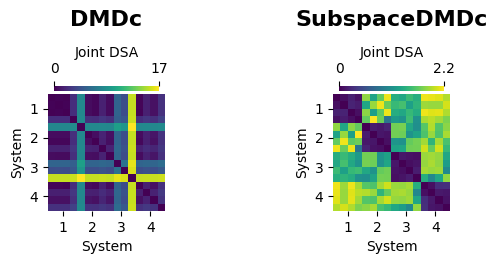

In [14]:
# Get the similarity matrices for each method
sims_full_dmdc, _, _, _, _ = compare_systems_full(A_cs, B_cs)
sims_full_subdmdc, _, _, _, _ = compare_systems_full(As_n4sid, Bs_n4sid)

# Print silhouette scores
print("Silhouette Scores:")
print(f"DMDc Full (state): {np.round(silhouette_score(sims_full_dmdc, state_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc Full (state): {np.round(silhouette_score(sims_full_subdmdc, state_labels, metric='precomputed'), 3)}")
print(f"DMDc Full (control): {np.round(silhouette_score(sims_full_dmdc, control_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc Full (control): {np.round(silhouette_score(sims_full_subdmdc, control_labels, metric='precomputed'), 3)}")

# Create 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Column headers (bold)
column_headers = ['DMDc', 'SubspaceDMDc']
for i, header in enumerate(column_headers):
    axes[i].text(0.5, 1.55, header, transform=axes[i].transAxes, ha='center', va='bottom', fontweight='bold', fontsize=16)

# Data for each subplot
data_matrices = [
    sims_full_dmdc,    # left
    sims_full_subdmdc  # right
]

# Plot each subplot
for idx, (ax, data) in enumerate(zip(axes.flat, data_matrices)):
    im = ax.imshow(data, cmap='viridis')
    
    # Add colorbar on top with only 2 ticks
    cbar = plt.colorbar(im, ax=ax, shrink=0.4, location='top', pad=0.02,label='Joint DSA')
    vmin, vmax = data.min(), data.max()
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([f'{vmin:.2g}', f'{vmax:.2g}'])
    cbar.ax.tick_params(labelsize=10)
    
    # Remove colorbar spines
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)
    
    # Set custom tick positions and labels (every 4 positions)
    tick_positions = [1.5, 5.5, 9.5, 13.5]  # Middle of each group of 4
    tick_labels = ['1', '2', '3', '4']
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=10)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels, fontsize=10)
    
    # Set axis labels
    ax.set_xlabel('System', fontsize=10)
    ax.set_ylabel('System', fontsize=10)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()


In [15]:
#collect statistics now: 
#sample random systems from the set of 4 pairings
#sample 4 input drives for each system, making 16 diferent systems in total 
#compute silhouette score based on A labels and B labels

def get_silhouette_scores(n,m,p_out,N,n_iters,
    input_alpha=input_alpha,g1=g1,g2=g2,same_inp=False,n_Us=n_Us,
    n_delays=n_delays,pf=pf,rank=rank,process_noise=process_noise,obs_noise=obs_noise,
    nonlinear_eps=nonlinear_eps,nonlinear_func=lambda x: np.tanh(x),
    y_feature_map = lambda x: x, u_feature_map = lambda x: x,backend=backend,
    use_joint_control=True):

    silhouette_state_dmdc = []
    silhouette_control_dmdc = []

    silhouette_state_subspace_dmdc = []
    silhouette_control_subspace_dmdc = []

    silhouette_state_dsa = []
    silhouette_control_dsa = []


    for i in tqdm(range(n_iters)):
        X_trues, Ys, Us, control_labels, state_labels, *_ = simulate_As_Bs(n,m,p_out,
            N,input_alpha=input_alpha,g1=g1,g2=g2,same_inp=same_inp,n_Us=n_Us, seed1=seed1+i,seed2=seed2+110*i,
            obs_noise=obs_noise,process_noise=process_noise,
            nonlinear_eps=nonlinear_eps,nonlinear_func=nonlinear_func)
        Ys = list(map(y_feature_map, Ys))
        Us = list(map(u_feature_map, Us))

        A_cs, B_cs = get_dmdcs(Ys,Us,n_delays=n_delays,rank=rank)
        print('dmdc:', [i.shape for i in A_cs])
        As, Bs, Cs, infos = get_subspace_dmdcs(Ys,Us,p=pf,rank=rank,backend=backend)
        print('subspacedmdc:', [i.shape for i in As])
        A_dmds = get_dmds(Ys,n_delays=n_delays,rank=rank)
        print('dmd:', [i.shape for i in A_dmds])
        sims_full_dmdc, sims_control_joint_dmdc, sims_state_joint_dmdc, sims_control_separate_dmdc, sims_state_separate_dmdc = compare_systems_full(A_cs,B_cs)
        sims_full_subspace_dmdc, sims_control_joint_subspace_dmdc, sims_state_joint_subspace_dmdc, sims_control_separate_subspace_dmdc, sims_state_separate_subspace_dmdc = compare_systems_full(As,Bs)

        sims_state_dmd = compare_A_full(A_dmds)

        #compute silhouette scores
        silhouette_state_dmdc.append(silhouette_score(sims_state_separate_dmdc,state_labels,metric='precomputed'))
        if use_joint_control:
            silhouette_control_dmdc.append(silhouette_score(sims_control_joint_dmdc,control_labels,metric='precomputed'))
            silhouette_control_subspace_dmdc.append(silhouette_score(sims_control_joint_subspace_dmdc,control_labels,metric='precomputed'))
        else:
            silhouette_control_dmdc.append(silhouette_score(sims_control_separate_dmdc,control_labels,metric='precomputed'))
            silhouette_control_subspace_dmdc.append(silhouette_score(sims_control_separate_subspace_dmdc,control_labels,metric='precomputed'))
            
        silhouette_state_subspace_dmdc.append(silhouette_score(sims_state_separate_subspace_dmdc,state_labels,metric='precomputed'))

        silhouette_state_dsa.append(silhouette_score(sims_state_dmd,state_labels,metric='precomputed'))
        silhouette_control_dsa.append(silhouette_score(sims_state_dmd,control_labels,metric='precomputed'))

        print(silhouette_state_subspace_dmdc[-1],silhouette_state_dmdc[-1])
        print(silhouette_control_subspace_dmdc[-1],silhouette_control_dmdc[-1])

        # print(silhouette_state_subspace_dmdc,silhouette_control_subspace_dmdc)
    return silhouette_state_dmdc, silhouette_control_dmdc, silhouette_state_subspace_dmdc, silhouette_control_subspace_dmdc, silhouette_state_dsa, silhouette_control_dsa



In [16]:
n_iters = 10
silh_state_dmdc, silh_ctrl_dmdc, silh_state_subdmdc, silh_ctrl_subsdmdc, silh_state_dsa, silh_ctrl_dsa = get_silhouette_scores(n,m,p_out_small,
                                                                                                                5*N_small,n_iters,input_alpha=input_alpha,g1=g1,
                                                                                                               g2=g2,same_inp=False,n_Us=n_Us,n_delays=n_delays,rank=rank,pf=pf,
                                                                                                              obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps,
                                                                                                              backend=backend)

  0%|          | 0/10 [00:00<?, ?it/s]

dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 10%|█         | 1/10 [01:28<13:18, 88.69s/it]

0.7314581775975633 0.16104723750004596
0.5440073682689835 -0.005069860092856
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 20%|██        | 2/10 [02:50<11:18, 84.78s/it]

0.7827317078625082 0.5825996971295835
0.3229498257196527 0.06869502574614386
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 30%|███       | 3/10 [04:21<10:13, 87.60s/it]

0.7798420180961111 0.40995024638304634
0.32616103914219824 -0.010052184122752855
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 40%|████      | 4/10 [05:41<08:26, 84.45s/it]

0.7834359371571857 0.29661996683140296
0.5536270218171802 -0.005099222915686
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 50%|█████     | 5/10 [07:10<07:10, 86.11s/it]

0.9054367099706238 0.9944485211060505
0.0926481065351533 0.08810436324269391
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 60%|██████    | 6/10 [08:28<05:33, 83.39s/it]

0.7505711873525638 0.8674439303320105
0.3632658274435374 -0.040285158227859094
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 70%|███████   | 7/10 [09:56<04:14, 84.93s/it]

0.5411354753152422 0.9356930949526279
0.29630851035216615 -0.005756604108780622
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 80%|████████  | 8/10 [11:16<02:46, 83.24s/it]

0.8014827220289453 0.9275857467108388
0.4135891587644902 0.08507401928773778
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


 90%|█████████ | 9/10 [12:44<01:24, 84.86s/it]

0.8561426176327349 0.8707047828363996
0.6723110849191525 0.08930277843138465
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


100%|██████████| 10/10 [14:05<00:00, 84.52s/it]

0.38086619486554607 0.3644571773667115
0.34339543282018914 -0.02225722394390728


[autoreload of DSA.subspace_dmdc failed: Traceback (most recent call last):
  File "/Users/mitchellostrow/opt/anaconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mitchellostrow/opt/anaconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/mitchellostrow/opt/anaconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/mitchellostrow/opt/anaconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/Users/mitchellostrow/opt/anaconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/mitchellostrow/opt/anacond

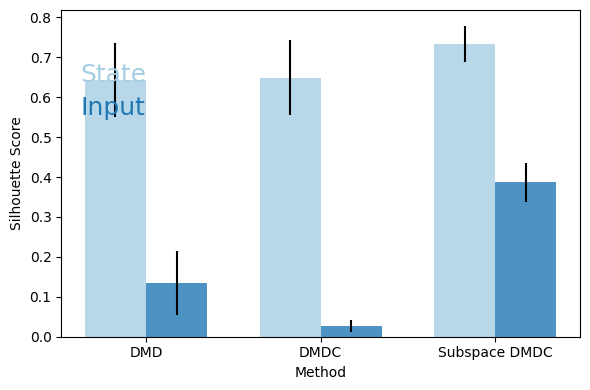

In [20]:
methods = [ 'DMD','DMDC', 'Subspace DMDC']
state_means = [np.mean(silh_state_dsa),np.mean(silh_state_dmdc), np.mean(silh_state_subdmdc)]
state_stds = [np.std(silh_state_dsa) / np.sqrt(n_iters), np.std(silh_state_dmdc) / np.sqrt(n_iters), np.std(silh_state_subdmdc) / np.sqrt(n_iters)]
control_means = [np.mean(silh_ctrl_dsa),np.mean(silh_ctrl_dmdc), np.mean(silh_ctrl_subsdmdc)]
control_stds = [np.std(silh_ctrl_dsa) / np.sqrt(n_iters), np.std(silh_ctrl_dmdc) / np.sqrt(n_iters), np.std(silh_ctrl_subsdmdc) / np.sqrt(n_iters)]

# Create bar plot
x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
# Prepare data for violin plots
state_data = [silh_state_dsa, silh_state_dmdc, silh_state_subdmdc]
control_data = [silh_ctrl_dsa, silh_ctrl_dmdc, silh_ctrl_subsdmdc]

# Option to create either violin plots or bar plots
plot_type = 'bar'  # Change to 'bar' for bar plots

if plot_type == 'violin':
    # Create violin plots
    violin_parts1 = ax.violinplot(state_data, positions=x - width/2, widths=width, showmeans=True, showmedians=False)
    violin_parts2 = ax.violinplot(control_data, positions=x + width/2, widths=width, showmeans=True, showmedians=False)

    # Color the violin plots
    for pc in violin_parts1['bodies']:
        pc.set_facecolor(plt.cm.Paired(0))
        pc.set_alpha(0.8)
        
    for pc in violin_parts2['bodies']:
        pc.set_facecolor(plt.cm.Paired(1))
        pc.set_alpha(0.8)

    # Set the color for violin lines (edges) as well
    for key in ['cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans']:
        if key in violin_parts2:
            violin_parts2[key].set_color(plt.cm.Paired(1))
    # Create legend manually
    # ax.plot([], [], color=plt.cm.Paired(0), alpha=0.8, label='State')
    # ax.plot([], [], color=plt.cm.Paired(1), alpha=0.8, label='Control')

elif plot_type == 'bar':
    # Create bar plots
    ax.bar(x - width/2, state_means, width, yerr=state_stds, alpha=0.8,color=plt.cm.Paired(0))
    ax.bar(x + width/2, control_means, width, yerr=control_stds, alpha=0.8,color=plt.cm.Paired(1))


ax.text(0.1, 0.8, 'State', color=plt.cm.Paired(0), fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.text(0.1, 0.7, 'Input', color=plt.cm.Paired(1), fontsize=18, ha='center', va='center', transform=ax.transAxes)


# Add labels and formatting
ax.set_xlabel('Method')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(x)
ax.set_xticklabels(methods)
# ax.legend(loc='upper left')

plt.tight_layout()
# plt.show()

In [ ]:
#sweep partial observation fraction and compute silhouette scores

n_iters = 20


silh_state_dmdcs = []
silh_ctrl_dmdcs = []
silh_state_subdmdcs = []
silh_ctrl_subsdmdcs = []
silh_state_dsas = []
silh_ctrl_dsas = []

# p_outs = [1] #+ np.arange(2,22,2).tolist()
p_out = 2
n_uses = [2, 4, 6, 8, 10, 20, 50, 100, 200, 500,1000] #[::-1]
for n_use in n_uses:
    print(n_use)
    ss_dmdc, sc_dmdc, ss_subdmdc, sc_subdmdc, ss_dsa, sc_dsa = get_silhouette_scores(n_use,m,p_out,
                                                                        5*N_small,n_iters,input_alpha=input_alpha,g1=g1,
                                                                        g2=g2,same_inp=False,n_Us=n_Us,n_delays=n_delays,rank=min(n_use,100),pf=pf,
                                                                        obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps)
    silh_state_dmdcs.append(ss_dmdc)
    silh_ctrl_dmdcs.append(sc_dmdc)
    silh_state_subdmdcs.append(ss_subdmdc)
    silh_ctrl_subsdmdcs.append(sc_subdmdc)
    silh_state_dsas.append(ss_dsa)
    silh_ctrl_dsas.append(sc_dsa)

    print(np.mean(ss_dmdc),np.mean(ss_subdmdc),np.mean(ss_dsa))
    print()


silh_state_dmdcs = np.array(silh_state_dmdcs)
silh_state_subdmdcs = np.array(silh_state_subdmdcs)
silh_state_dsas = np.array(silh_state_dsas)
silh_ctrl_dmdcs = np.array(silh_ctrl_dmdcs)
silh_ctrl_subdmdcs = np.array(silh_ctrl_subsdmdcs)
silh_ctrl_dsas = np.array(silh_ctrl_dsas)


2


  5%|▌         | 1/20 [00:50<15:50, 50.01s/it]

0.9999995829788267 0.9994804238352938
0.863046118997211 0.23133393565678578


 10%|█         | 2/20 [01:38<14:41, 48.98s/it]

0.9999996460530998 0.5761319024802469
0.8701154730521196 0.24099690133052715


 15%|█▌        | 3/20 [02:26<13:48, 48.71s/it]

0.9999912817283558 0.9521479914270492
0.16003234487022538 0.16403266188793597


 20%|██        | 4/20 [03:14<12:56, 48.55s/it]

0.999997826126348 0.9976338825933455
0.3814445884235741 0.2529392671562286


 25%|██▌       | 5/20 [04:03<12:06, 48.46s/it]

0.9999999679564451 0.9920394705518483
0.010578386107770881 0.04765377864976594


 30%|███       | 6/20 [04:52<11:21, 48.69s/it]

0.9999999889902481 0.9689650322969088
0.5630268469649073 0.3016799456824357


 35%|███▌      | 7/20 [05:40<10:29, 48.40s/it]

0.9999998497630886 0.3183726653904416
0.9534753079734178 0.2617349582738815


 40%|████      | 8/20 [06:28<09:39, 48.33s/it]

0.9999993846554156 0.8273921704738043
0.9949309508072234 0.21925306644298592


 45%|████▌     | 9/20 [07:16<08:52, 48.37s/it]

0.9999999392047036 0.9954893728664165
0.8926091704516487 0.1903970895833016


 50%|█████     | 10/20 [08:04<08:02, 48.27s/it]

0.9999999896719519 0.995444964889423
0.9961439015917473 0.2041291174096036


 55%|█████▌    | 11/20 [08:52<07:14, 48.22s/it]

0.9999999238686303 0.9972320906387236
0.9583486457958001 0.2825033975417309


 60%|██████    | 12/20 [09:41<06:25, 48.17s/it]

0.9999384251308399 0.3684689139358635
0.47414138222768587 0.0851508391625842


 65%|██████▌   | 13/20 [10:29<05:36, 48.12s/it]

0.9999999348885965 0.7527879372104045
0.6306063443490444 0.2672479104166636


 70%|███████   | 14/20 [11:16<04:48, 48.03s/it]

0.9999951190598705 0.3610613497907184
0.8961250841720869 0.2641135351952263


 75%|███████▌  | 15/20 [12:05<04:00, 48.17s/it]

0.999998341385793 0.6230706090075946
0.9248202840122726 0.17706479248767715


 80%|████████  | 16/20 [12:53<03:12, 48.06s/it]

0.9999999674326947 0.9994709308073931
-0.1067841427238009 -0.09112366530336576


 85%|████████▌ | 17/20 [13:41<02:24, 48.21s/it]

0.999999868783956 0.20194098857734308
0.7239155278059701 -0.0724678271629539


 90%|█████████ | 18/20 [14:29<01:36, 48.14s/it]

0.9999997066328019 0.819120040107554
0.8702333799674973 0.05895311655939994


 95%|█████████▌| 19/20 [15:17<00:48, 48.06s/it]

0.9999998800189802 0.9349864382675056
0.5766529970474021 0.14812653792397995


100%|██████████| 20/20 [16:06<00:00, 48.32s/it]


0.9999999876386543 0.9989465989638291
-0.10880975421142923 -0.041194873224640466
0.7840091887055854 0.9999959305984649 0.8177832037795628

4


  5%|▌         | 1/20 [00:49<15:31, 49.00s/it]

0.7148854335890451 0.3570867373101759
0.254784330813526 0.2564970447924318


 10%|█         | 2/20 [01:37<14:32, 48.48s/it]

0.9991213701183851 0.9338003716720993
0.373621258031336 0.192136675493342


 15%|█▌        | 3/20 [02:25<13:41, 48.30s/it]

0.6355829754026776 0.9872634331292893
0.1854906962368728 -0.03767345531702448


 20%|██        | 4/20 [03:13<12:51, 48.24s/it]

0.9995839406566759 0.9953287380325818
0.6123764433477282 0.08684510901067677


 25%|██▌       | 5/20 [04:03<12:12, 48.84s/it]

0.6963230455649736 0.845687225356722
0.4016672245447243 0.058871525818189774


 30%|███       | 6/20 [05:09<12:48, 54.92s/it]

0.9992640993428434 0.998645561471499
0.8038460988934154 0.2454871038684441


 35%|███▌      | 7/20 [06:15<12:40, 58.47s/it]

0.9987683545735093 0.0736808970230497
0.8285925196418789 0.2732293212884245


 40%|████      | 8/20 [07:22<12:14, 61.24s/it]

0.9915730805336032 0.994797192140245
0.5981192746869755 0.1964379017215781


 45%|████▌     | 9/20 [08:27<11:25, 62.34s/it]

0.16730169440098075 -0.050823293824917536
0.856633281362433 0.7165541780129958


 50%|█████     | 10/20 [09:33<10:33, 63.33s/it]

0.9955512573222484 0.4421153238515224
0.7824419645630796 0.27359514600465207


 55%|█████▌    | 11/20 [10:36<09:30, 63.40s/it]

0.9999171575551626 0.3104755396741338
0.4001872470668205 0.16345363658381468


 60%|██████    | 12/20 [11:40<08:27, 63.42s/it]

0.9483586189931417 0.966822117653678
0.7168567181733992 0.12511920485220757


 65%|██████▌   | 13/20 [12:44<07:26, 63.78s/it]

0.9561742831184827 0.9966754990231261
0.9029807911758108 0.2610828125429131


 70%|███████   | 14/20 [13:49<06:24, 64.02s/it]

0.9990568101519974 0.7746559801011399
0.9337617390487356 0.3075022066959726


 75%|███████▌  | 15/20 [14:53<05:20, 64.16s/it]

0.9998411060381232 0.2569602675253595
0.8390945275201664 0.22370357604102423


 80%|████████  | 16/20 [15:57<04:16, 64.06s/it]

0.9997865367342857 0.241318053358768
0.6837142493572079 0.07254009908039336


 85%|████████▌ | 17/20 [16:59<03:10, 63.47s/it]

0.8785750042711452 0.810468321924495
0.570785198489913 0.27891043801749216


 90%|█████████ | 18/20 [18:04<02:07, 63.84s/it]

0.9995900377560776 0.9195043770087221
0.9833055223571778 0.3036383897052762


 95%|█████████▌| 19/20 [19:01<01:01, 61.76s/it]

0.2812199039990566 0.3239224658462285
0.6939734888761797 0.2935816367842393


100%|██████████| 20/20 [20:04<00:00, 60.20s/it]


0.9660441509081211 0.42782272440222124
0.8648016287642502 0.4537986269330362
0.630310376634007 0.8613259430515268 0.6772214951028864

6


  5%|▌         | 1/20 [00:57<18:09, 57.32s/it]

0.6829675131066244 0.4223460413096838
0.8854467748170356 0.2616686133906402


 10%|█         | 2/20 [01:55<17:18, 57.68s/it]

0.4778190008236387 0.17609356285751082
0.6598414498361063 0.22278253995276884


 15%|█▌        | 3/20 [02:53<16:23, 57.88s/it]

0.5471160613933711 0.08871996231037635
0.4259459201932812 0.1866660821930045


 20%|██        | 4/20 [03:50<15:19, 57.48s/it]

0.8016038453841238 0.9988028414222979
0.8509811383108216 0.2604414799956156


 25%|██▌       | 5/20 [04:48<14:27, 57.83s/it]

0.7321304877045927 0.9301852495572647
0.8173496247672856 0.12185147255399653


 30%|███       | 6/20 [05:48<13:37, 58.39s/it]

0.6365979901030729 0.4041255920722771
0.7579932786817185 0.18545833884321933


 35%|███▌      | 7/20 [06:45<12:36, 58.17s/it]

0.9195536285180825 0.9806066331854593
0.7777951467327848 0.28973384255619494


 40%|████      | 8/20 [07:41<11:28, 57.37s/it]

0.984003610143904 0.9995813967756805
0.8788713016811251 0.2749585482464467


 45%|████▌     | 9/20 [08:39<10:33, 57.58s/it]

0.5158567945640098 -0.07237010093454069
0.9126702269824578 0.49939973342165545


 50%|█████     | 10/20 [09:35<09:30, 57.05s/it]

0.7923416282245809 0.2817045952973056
0.7779161159103634 0.24577059528112646


 55%|█████▌    | 11/20 [10:30<08:28, 56.54s/it]

0.7312936187732099 0.9473852533471532
0.7597158791730374 0.18176727052706398


 60%|██████    | 12/20 [11:24<07:25, 55.64s/it]

0.6469929404560593 0.3729713725848219
0.40568443893046857 0.2157982900886147


 65%|██████▌   | 13/20 [12:17<06:24, 54.87s/it]

0.7282137874227994 0.381613387917653
0.7096534869397652 0.32360433315080395


 70%|███████   | 14/20 [13:09<05:23, 53.98s/it]

0.8932251993393823 0.9698401650825509
0.7012288905220221 0.240646029051426


 75%|███████▌  | 15/20 [14:02<04:29, 53.85s/it]

0.8119149687546602 0.2780525694562858
0.7676685570825138 0.24978632748796964


 80%|████████  | 16/20 [14:56<03:34, 53.63s/it]

0.4208085507139975 0.19105960199501956
0.4335780142580806 0.16747429030574595


 85%|████████▌ | 17/20 [15:49<02:40, 53.50s/it]

0.7648091158857311 0.8826299558795999
0.5728535489842801 0.15178372322416311


 90%|█████████ | 18/20 [16:52<01:52, 56.40s/it]

0.7153545536283132 0.8906240461622843
0.9652633954881787 0.2609344859351437


 95%|█████████▌| 19/20 [17:54<00:58, 58.10s/it]

0.5778547187917267 0.44230974875355167
0.8466528891503173 0.07585444605775558


100%|██████████| 20/20 [18:50<00:00, 56.52s/it]


0.8191002897878881 0.368712975313898
0.8319921385680488 0.28762059488907493
0.5467497425173066 0.7099779151759884 0.5484566045827914

8


  5%|▌         | 1/20 [00:53<17:02, 53.81s/it]

0.9248303386842245 0.7146369776756394
0.7451216619675085 0.23952590552851677


 10%|█         | 2/20 [01:48<16:13, 54.08s/it]

0.7832002042045016 0.3089931254863645
0.6649420392703927 0.11572462988981133


 15%|█▌        | 3/20 [02:41<15:13, 53.73s/it]

0.6435735655396131 0.20445585902685298
0.872934293916127 0.2747311850562459


 20%|██        | 4/20 [03:35<14:18, 53.68s/it]

0.706631097080003 0.9684960879289083
0.48356213906831524 0.20405758550928416


 25%|██▌       | 5/20 [04:30<13:33, 54.23s/it]

0.9661794181953494 0.32230796996366945
0.8934327360343968 0.35701384353475246


 30%|███       | 6/20 [05:23<12:34, 53.90s/it]

0.9553748648518876 0.39828794838648274
0.7830886629530971 0.22893819637325005


 35%|███▌      | 7/20 [06:18<11:44, 54.23s/it]

0.8147103362485131 0.0988428621121708
0.9470716284359546 0.3104522087632273


 40%|████      | 8/20 [07:11<10:47, 53.96s/it]

0.9767647013433851 0.7556305630672474
0.943084645089665 0.10792093436819339


 45%|████▌     | 9/20 [08:05<09:54, 54.05s/it]

0.8085664544760404 0.34372255960639364
0.9022105132439618 0.21804741703514957


 50%|█████     | 10/20 [08:58<08:56, 53.63s/it]

0.7606182512852901 0.4256418262830215
0.8894219397963725 0.2948401293001088


 55%|█████▌    | 11/20 [09:52<08:03, 53.72s/it]

0.6282569085372263 0.3089051839947159
0.8012605799820862 0.24923431995121953


 60%|██████    | 12/20 [10:46<07:09, 53.75s/it]

0.9255080438194763 0.8188655274348823
0.7987398983988274 0.14982915606986894


 65%|██████▌   | 13/20 [11:39<06:15, 53.61s/it]

0.917964256305034 0.935502457207692
0.6930882697627829 0.22298600961410608


 70%|███████   | 14/20 [12:32<05:20, 53.42s/it]

0.6367458407978331 0.35127711063627737
0.5818592184667145 0.27120945643360456


 75%|███████▌  | 15/20 [13:26<04:28, 53.63s/it]

0.8304468291687427 0.18779258604062105
0.6704730508807738 0.24147650357533848


 80%|████████  | 16/20 [14:18<03:32, 53.05s/it]

0.9894151988315718 0.9953587181268179
0.24522148086447199 0.2299362315813862


 85%|████████▌ | 17/20 [15:10<02:38, 52.78s/it]

0.6041337842499772 0.33126028917602063
0.9598960458391113 0.3595816525605222


 90%|█████████ | 18/20 [16:02<01:45, 52.59s/it]

0.9685427305295512 0.9324988048230214
0.4098858470516994 0.3098063660817312


 95%|█████████▌| 19/20 [16:57<00:53, 53.15s/it]

0.8142915376417594 0.34116724781207
0.9629912195463708 0.16932229722168923


100%|██████████| 20/20 [17:49<00:00, 53.50s/it]


0.8214845853326898 0.23004491704025687
0.7719468109436691 0.25361105460709327
0.4986844310914563 0.8238619473561336 0.5526251265224809

10


  5%|▌         | 1/20 [00:53<16:48, 53.10s/it]

0.7991433678090709 0.565793146732338
0.6580735402758165 0.2469688530509827


 10%|█         | 2/20 [01:47<16:06, 53.71s/it]

0.6407325038895381 0.40472342435440967
0.42905662200774763 0.06822521009658045


 15%|█▌        | 3/20 [02:40<15:09, 53.52s/it]

0.8461176454032904 0.3138150886305985
0.6417382914134774 0.3695419197033751


 20%|██        | 4/20 [03:34<14:19, 53.71s/it]

0.5371381446176151 0.3640210948047854
0.47543343188655235 0.3412147377093789


 25%|██▌       | 5/20 [04:29<13:30, 54.04s/it]

0.4817741069115222 0.3312604718736136
0.921089351917504 0.28936051553243025


 30%|███       | 6/20 [05:23<12:37, 54.08s/it]

0.9687073854918788 0.9991191759574398
0.9241084179945119 0.12928319716867753


 35%|███▌      | 7/20 [06:23<12:07, 55.93s/it]

0.4295218657374844 0.11410334626856197
0.894517240546653 0.2000469265578521


 40%|████      | 8/20 [07:21<11:22, 56.88s/it]

0.33677496103480126 -0.08890655024206669
0.8852859753982001 0.32121996122835905


 45%|████▌     | 9/20 [08:18<10:25, 56.84s/it]

0.8001191065128971 0.8390420933339114
0.8682404172168996 0.31176429277749024


 50%|█████     | 10/20 [09:13<09:23, 56.34s/it]

0.6306414649718846 0.760817453744526
0.7830045461575633 0.25697639413796286


 55%|█████▌    | 11/20 [10:09<08:26, 56.23s/it]

0.9700886369661625 0.3402876141906415
0.479714946691821 0.21419923744792801


 60%|██████    | 12/20 [11:07<07:32, 56.56s/it]

0.7112346911590584 0.8115064155105561
0.892931950721412 0.15764011379775023


 65%|██████▌   | 13/20 [12:03<06:36, 56.60s/it]

0.7012834016157923 0.14910716991895367
0.8036564778741786 0.2426703326352978


 70%|███████   | 14/20 [13:02<05:43, 57.26s/it]

0.7875423195769864 0.7459283517299533
0.6840405260414184 0.12612654890845015


 75%|███████▌  | 15/20 [14:02<04:49, 57.87s/it]

0.5680739236743386 0.6798750591982248
0.7685265107130248 0.21111568535663267


 80%|████████  | 16/20 [14:56<03:47, 56.91s/it]

0.8969783486575266 0.8201654338199273
0.6419161613136062 0.3102890006181207


 85%|████████▌ | 17/20 [15:50<02:48, 56.04s/it]

0.2102115990246819 0.681500023791654
0.9457387099496892 0.27367950454988077


 90%|█████████ | 18/20 [16:48<01:53, 56.55s/it]

0.7230200609338846 0.4987655547588908
0.8993263982985391 0.32930054005012344


 95%|█████████▌| 19/20 [17:43<00:56, 56.10s/it]

0.4811909979021496 0.34295258004093626
0.984001565270018 0.17301095039273662


100%|██████████| 20/20 [18:41<00:00, 56.09s/it]


0.9145787220471548 0.47275372687986705
0.9310953047402001 0.22434178009172623
0.5073315337648862 0.6717436626968859 0.5167306060806733

20


  5%|▌         | 1/20 [00:57<18:21, 57.96s/it]

0.9892640331231699 0.8594591384334251
0.8254778135215022 0.214267756737885


 10%|█         | 2/20 [01:56<17:26, 58.15s/it]

0.9512447101134738 0.4068049229052108
0.736197252981335 0.1987269496108924


 15%|█▌        | 3/20 [02:53<16:23, 57.88s/it]

0.8785697149599488 0.6235207265603029
0.6158978028372307 0.24119758793689644


 20%|██        | 4/20 [03:50<15:18, 57.40s/it]

0.7442104757416566 0.2526657447637686
0.7914724527675518 0.3287430462844653


 25%|██▌       | 5/20 [04:49<14:28, 57.90s/it]

0.8749731165405094 0.38901877685785274
0.9143839901122117 0.3008742080828827


 30%|███       | 6/20 [05:46<13:29, 57.80s/it]

0.7524401849433755 0.5273911397333929
0.8560878537175243 0.27101413652478457


 35%|███▌      | 7/20 [06:49<12:52, 59.46s/it]

0.18044896982307718 0.14029720452084493
0.8081506503339186 0.19824224783168232


 40%|████      | 8/20 [07:50<11:56, 59.74s/it]

0.9770507781642589 0.7183770834927682
0.26385329595023455 0.115051332187116


 45%|████▌     | 9/20 [08:49<10:54, 59.51s/it]

0.5358649236504333 0.6741896151072617
0.8652764268463012 0.2600824214341021


 50%|█████     | 10/20 [09:50<09:59, 59.99s/it]

0.7370445733058059 0.21205111557687406
0.9575139770925202 0.5804208804017441


 55%|█████▌    | 11/20 [10:49<08:58, 59.79s/it]

0.7010619836064139 0.8787181635255477
0.39316111137823206 0.22912150415632226


 60%|██████    | 12/20 [11:46<07:50, 58.80s/it]

0.511356583372921 0.9090642506020197
0.8585437451244906 0.3032818384153309


 65%|██████▌   | 13/20 [12:41<06:44, 57.78s/it]

0.8422170048715416 0.4655938834297251
0.9246601826856204 0.25795015987507086


 70%|███████   | 14/20 [13:37<05:42, 57.14s/it]

0.5393678866134317 0.16183292650561076
0.6668216456383955 0.19683088749074412


 75%|███████▌  | 15/20 [14:36<04:48, 57.69s/it]

0.9385038404707957 0.7075567029351021
0.7926214453281066 0.2651271505385519


 80%|████████  | 16/20 [15:33<03:50, 57.55s/it]

0.9396540889153789 0.71283293556484
0.955523845385363 0.28787200438430793


 85%|████████▌ | 17/20 [16:29<02:51, 57.09s/it]

0.7483994134243397 0.9725720264591999
0.7723355923572701 0.23929991033336254


 90%|█████████ | 18/20 [17:25<01:53, 56.71s/it]

0.963901587135688 0.725603976138003
0.874380533643646 0.39667421074578557


 95%|█████████▌| 19/20 [18:20<00:56, 56.16s/it]

0.8335779478889345 0.429612405947956
0.6335114677482351 0.32923557189268776


100%|██████████| 20/20 [19:16<00:00, 57.80s/it]


0.7048793856690092 0.5371596636189394
0.9764039741453683 0.2923650669525318
0.5652161201339324 0.7672015601167083 0.5580053587875079

50


  5%|▌         | 1/20 [01:12<22:54, 72.33s/it]

0.2860380003458474 0.3105522329810055
0.8752166267181785 0.5155899527565754


 10%|█         | 2/20 [02:26<22:03, 73.51s/it]

0.5898848214821798 0.45556156918402146
0.6069604392366142 0.2936238949125084


 15%|█▌        | 3/20 [03:37<20:29, 72.32s/it]

0.7320529918600682 0.8521377298136814
0.9029918902655901 0.2876787842363736


 20%|██        | 4/20 [04:47<19:04, 71.56s/it]

0.539977020978684 0.4945501601133633
0.6153494078059176 0.24901310001351387


 25%|██▌       | 5/20 [06:00<17:56, 71.78s/it]

0.21960990625785626 0.18522784750233728
0.5309055215391791 0.4288068204167372


 30%|███       | 6/20 [07:11<16:42, 71.62s/it]

0.6459410466940635 0.011299983501322868
0.9483473503631741 0.4318358565300766


 35%|███▌      | 7/20 [08:22<15:28, 71.45s/it]

0.42576715973064605 0.31801706152072473
0.7561012171300019 0.34173896506185514


 40%|████      | 8/20 [09:34<14:18, 71.55s/it]

0.8848059959184817 0.688873283915466
0.8467319580550701 0.2723758348586194


 45%|████▌     | 9/20 [10:47<13:12, 72.02s/it]

0.6394936234771974 0.27199690137762766
0.9632065247896976 0.3683824099393246


 50%|█████     | 10/20 [11:58<11:57, 71.75s/it]

0.8243466273351014 0.39518703428173496
0.9016127395936266 0.5168346307232419


 55%|█████▌    | 11/20 [13:10<10:45, 71.73s/it]

0.666926006575496 0.6990843787631436
0.6746058253840981 0.4336576557230802


 60%|██████    | 12/20 [14:22<09:35, 71.94s/it]

0.8956944324512491 0.23953877668101403
0.8504315319655691 0.4273766175223321


 65%|██████▌   | 13/20 [15:33<08:20, 71.57s/it]

0.6499095153580638 0.2245850900849572
0.8056497448834813 0.24283914573402143


 70%|███████   | 14/20 [16:45<07:10, 71.80s/it]

0.887792229639151 0.6347844805856808
0.8796551535411032 0.36216678946757896


 75%|███████▌  | 15/20 [17:59<06:01, 72.29s/it]

0.5086444268624157 0.0936516339750865
0.7878271994226096 0.42504508357141196


 80%|████████  | 16/20 [19:14<04:52, 73.21s/it]

0.11948895738930862 0.31070889043209277
0.5937901505822004 0.382057515121027


 85%|████████▌ | 17/20 [20:27<03:39, 73.07s/it]

0.49807007753376553 0.5953937744140247
0.5051521673419727 0.3233819925076515


 90%|█████████ | 18/20 [21:41<02:26, 73.37s/it]

0.3383236736143306 0.6032253506345908
0.7233016813318316 0.37123212471933364


 95%|█████████▌| 19/20 [22:51<01:12, 72.35s/it]

0.7190588170171746 0.7969780119901608
0.8585962210786311 0.2878671355020555


100%|██████████| 20/20 [24:00<00:00, 72.01s/it]


0.34565097190956035 0.10234097838994428
0.8181598910705421 0.4034857434846065
0.4141847585070991 0.5708738151215321 0.41546844901558033

100


  5%|▌         | 1/20 [02:29<47:28, 149.91s/it]

0.8446268725815469 0.7256464342912119
0.8273507722373987 0.5603376456698084


 10%|█         | 2/20 [05:01<45:16, 150.91s/it]

0.5457822603798255 0.21750971297207908
0.8546880341433041 0.35635946004801594


 15%|█▌        | 3/20 [07:33<42:57, 151.60s/it]

0.6715401504742341 0.33921036794768644
0.7607462917806747 0.40100202095421456


 20%|██        | 4/20 [10:08<40:44, 152.77s/it]

0.5267314701678696 0.6466412902454441
0.9278811439470444 0.425815857095872


 25%|██▌       | 5/20 [12:46<38:40, 154.72s/it]

0.4643429036975759 0.190965385996421
0.9294583058441246 0.6218037387658151


 30%|███       | 6/20 [15:20<36:01, 154.40s/it]

0.709206644599262 0.33229187867188287
0.6681369604804535 0.5088500240453075


 35%|███▌      | 7/20 [17:55<33:29, 154.61s/it]

0.2314738406844464 0.06774352764780177
0.916137156986661 0.4823204525486465


 40%|████      | 8/20 [20:27<30:46, 153.90s/it]

0.4078497168933002 0.5483546343845598
0.9390646310432331 0.5249700522658651


 45%|████▌     | 9/20 [23:10<28:43, 156.65s/it]

0.8576657585702796 0.27128668076026385
0.8870119230779476 0.5507856621345018


 50%|█████     | 10/20 [25:41<25:48, 154.84s/it]

0.7253773211988085 0.2804275006355139
0.9014721499938876 0.5419448466702601


 55%|█████▌    | 11/20 [28:00<22:29, 149.95s/it]

0.33641812436974 0.35422686708680384
0.877598941516769 0.49945679860528824


 60%|██████    | 12/20 [30:34<20:10, 151.29s/it]

0.8753192957665168 0.280436722323244
0.87155131343598 0.4605904753540729


 65%|██████▌   | 13/20 [33:14<17:58, 154.04s/it]

0.0788372675369562 0.356938915948146
0.9434898139880066 0.5660042178199005


 70%|███████   | 14/20 [35:51<15:28, 154.83s/it]

0.13548756460266684 0.3020333447007765
0.8355524739767075 0.4803127179691466


 75%|███████▌  | 15/20 [38:28<12:56, 155.30s/it]

0.15113425915118855 -0.012416282573434669
0.9499796252950421 0.4505210752534833


 80%|████████  | 16/20 [41:04<10:22, 155.73s/it]

0.7603783923118979 0.3960604328259445
0.5260696835489838 0.2634785255655468


 85%|████████▌ | 17/20 [43:23<07:31, 150.55s/it]

0.6931923903264781 0.5476441672681036
0.5774190372196778 0.37382427961108844


 90%|█████████ | 18/20 [45:51<04:59, 149.79s/it]

0.8499123123044735 0.5544635520573259
0.869813808721149 0.4762205555314316


 95%|█████████▌| 19/20 [48:09<02:26, 146.25s/it]

0.5867010922012843 0.10158268344160948
0.9031706778944122 0.6281068800498706


100%|██████████| 20/20 [50:38<00:00, 151.92s/it]


0.4224749726743423 0.24078994145418864
0.9225045347541461 0.49925414194469775
0.3370918879042787 0.5437226305246348 0.38753305360921275

200


  5%|▌         | 1/20 [02:38<50:05, 158.17s/it]

0.5909926793101823 0.5267353297787027
0.793287839335513 0.42577658486413167


 10%|█         | 2/20 [05:17<47:44, 159.11s/it]

0.6247010938533479 0.2711818540152699
0.944896066035209 0.5541491013249726


 15%|█▌        | 3/20 [07:53<44:35, 157.38s/it]

0.40754480344278765 0.12368201193512694
0.7442620102045194 0.48312609484057234


 20%|██        | 4/20 [10:36<42:35, 159.71s/it]

0.5789496801447473 0.26461895585748385
0.7904986694139292 0.5211463345792007


 25%|██▌       | 5/20 [13:21<40:23, 161.55s/it]

0.658181489951501 0.4111157930411643
0.8767443415128332 0.41738304427727346


 30%|███       | 6/20 [15:46<36:24, 156.03s/it]

0.5890209837764785 0.31261881183448553
0.7431785673340168 0.43313114828135746


 35%|███▌      | 7/20 [18:22<33:48, 156.06s/it]

0.25878407195050107 0.248673711901176
0.960555865133256 0.602995612582953


 40%|████      | 8/20 [20:56<31:03, 155.28s/it]

0.1831344683291642 0.7502605606731848
0.7419020251917682 0.44774711485528707


 45%|████▌     | 9/20 [23:39<28:55, 157.79s/it]

0.6156212189531662 0.30370286626147514
0.8113055539834164 0.5869938172389021


 50%|█████     | 10/20 [26:22<26:32, 159.21s/it]

0.25602000113544043 0.20566905280002584
0.8723014637982822 0.40689361063820395


 55%|█████▌    | 11/20 [29:03<23:58, 159.81s/it]

0.08782627932844758 0.21599346406778525
0.9338566334595068 0.7108388099126532


 60%|██████    | 12/20 [31:25<20:35, 154.38s/it]

0.7509720423118675 0.31559635433883176
0.8671199750284003 0.5852102479633505


 65%|██████▌   | 13/20 [33:59<18:00, 154.41s/it]

0.23497824333432582 0.20581158461935417
0.8292549170886632 0.4671277111079004


 70%|███████   | 14/20 [36:30<15:19, 153.21s/it]

0.21076681207816744 0.05435857097436688
0.8983166829817066 0.6088961437819176


 75%|███████▌  | 15/20 [38:59<12:39, 151.91s/it]

0.43216414491713195 0.2700225343287927
0.9219818012435689 0.5448139659231047


 80%|████████  | 16/20 [41:39<10:17, 154.43s/it]

0.35107496005046335 0.17495664975537167
0.8019340960503707 0.4185433604322402


 85%|████████▌ | 17/20 [43:57<07:28, 149.65s/it]

0.7667975097980471 0.41876674952603615
0.4005731630535587 0.3527487793499603


 90%|█████████ | 18/20 [46:30<05:01, 150.53s/it]

0.48806800421228 0.7464100466923176
0.9245962301647113 0.5186315236551856


 95%|█████████▌| 19/20 [48:51<02:27, 147.77s/it]

0.23529197058614706 0.2865792918700654
0.8240179717146053 0.47096734519534117


100%|██████████| 20/20 [51:25<00:00, 154.26s/it]


0.5023233858774772 0.3795988310852768
0.9255917812733652 0.6415014495916215
0.3243176512678147 0.4411606921670835 0.32947940422530647

500


  5%|▌         | 1/20 [02:52<54:44, 172.86s/it]

0.22043632221253617 0.1553981097516287
0.9015436071811085 0.5472704301810019


 10%|█         | 2/20 [05:46<51:59, 173.33s/it]

0.6025273736285195 0.19152691356660215
0.8385417110841888 0.4769818571042821


 15%|█▌        | 3/20 [08:31<48:00, 169.45s/it]

0.5742814715509301 0.34682026258812115
0.9061019555563466 0.5823313202283038


 20%|██        | 4/20 [11:23<45:28, 170.53s/it]

0.26261340789480214 0.2719860300390877
0.9001388681520854 0.5518161850508868


 25%|██▌       | 5/20 [14:10<42:21, 169.41s/it]

0.21261855977293215 0.6854052550690519
0.7678151017058328 0.28790413421616146


 30%|███       | 6/20 [17:01<39:35, 169.69s/it]

0.1527939370789289 0.25347613159299026
0.7390842568896852 0.42379904680922015


 35%|███▌      | 7/20 [19:44<36:17, 167.48s/it]

0.2861601938983629 0.3523174081703131
0.8983865080718274 0.4778147328195415


 40%|████      | 8/20 [22:25<33:07, 165.61s/it]

0.1473331275960964 0.2616190097172466
0.8477978341974416 0.3867557529999165


 45%|████▌     | 9/20 [25:15<30:35, 166.82s/it]

0.8111390724509978 0.37228173553201405
0.8776929228510219 0.4795653764782277


 50%|█████     | 10/20 [28:05<27:59, 167.99s/it]

0.4085765746438009 0.34948545998649555
0.8007255529314821 0.3891526031748061


 55%|█████▌    | 11/20 [30:40<24:34, 163.81s/it]

0.13740835750248043 0.20976463111068544
0.9424595808849461 0.6339189675854268


 60%|██████    | 12/20 [33:37<22:22, 167.79s/it]

0.5112216206695892 0.23838856619317703
0.7904138275111404 0.4297397739791532


 65%|██████▌   | 13/20 [36:22<19:28, 166.95s/it]

0.0990374510279309 0.19216912255339327
0.9358155844669447 0.5563190397561102


 70%|███████   | 14/20 [39:10<16:45, 167.52s/it]

0.6601977913749432 0.27982790995797213
0.8684212521301466 0.5335795085482751


 75%|███████▌  | 15/20 [41:40<13:30, 162.17s/it]

0.5956458226808542 0.24524113278914392
0.7972147740858228 0.4332194784851243


 80%|████████  | 16/20 [44:25<10:52, 163.10s/it]

0.5122700595630902 0.488491597606007
0.8265298610883107 0.5350677727259068


 85%|████████▌ | 17/20 [47:18<08:17, 165.89s/it]

0.7476222074587422 0.6771672929832568
0.8479695857330589 0.4960150918510703


 90%|█████████ | 18/20 [50:06<05:33, 166.51s/it]

0.5302998066361749 0.2871918771799252
0.8765691515631118 0.47461433287297644


 95%|█████████▌| 19/20 [52:54<02:47, 167.18s/it]

0.15639471147498035 0.44150693921106593
0.8473852661332886 0.6010330942129157


100%|██████████| 20/20 [55:32<00:00, 166.64s/it]


0.8169119290035589 0.3552092297921594
0.8893471350212314 0.44209055341031084
0.33276373076951693 0.4222744899060126 0.33110059858440477

1000


  5%|▌         | 1/20 [03:20<1:03:20, 200.05s/it]

0.21599824061235723 0.2122759472603924
0.7939899099574769 0.47536600422017516


 10%|█         | 2/20 [06:50<1:01:46, 205.90s/it]

0.1772414590625133 0.1638066071548832
0.7768398756044337 0.5351219512328911


 15%|█▌        | 3/20 [10:20<58:53, 207.86s/it]  

0.20305987719615948 0.31641285252240126
0.8275996865695451 0.4554359223321068


 20%|██        | 4/20 [13:51<55:47, 209.21s/it]

0.4365103362894593 0.21617428873080619
0.9339548743077184 0.5467185377035322


 25%|██▌       | 5/20 [17:14<51:43, 206.93s/it]

0.5446757682556929 0.37759894045670706
0.9053551309392543 0.5450234643659914


 30%|███       | 6/20 [20:44<48:33, 208.08s/it]

0.3956405273624292 0.7379086544620574
0.9555669816927188 0.5676020992068349


 35%|███▌      | 7/20 [24:13<45:08, 208.33s/it]

0.6897428707916682 0.5966675741110706
0.893383950275017 0.6036722976049932


 40%|████      | 8/20 [27:53<42:24, 212.03s/it]

0.402043882408865 0.2152717511761012
0.8068825670591858 0.5761876966524075


 45%|████▌     | 9/20 [31:27<38:58, 212.61s/it]

0.1932406826463367 0.691683731087698
0.840336073582292 0.4572776129603895


 50%|█████     | 10/20 [34:48<34:50, 209.10s/it]

0.6452371929978948 0.6364881125494939
0.8706150369494879 0.49482891283103936


 55%|█████▌    | 11/20 [38:15<31:15, 208.38s/it]

0.6798123405096732 0.29606565488857894
0.33811609109222995 0.22316664135652803


 60%|██████    | 12/20 [41:53<28:11, 211.43s/it]

0.6521372440734303 0.500413621081764
0.783705095460566 0.39231804266732906


 65%|██████▌   | 13/20 [45:22<24:33, 210.57s/it]

0.6152243737606016 0.18487729125383087
0.9151161076602892 0.5136816998547024


 70%|███████   | 14/20 [48:48<20:54, 209.13s/it]

0.5863428471516422 0.26471775040865647
0.9251590994184722 0.5257523396494801


 75%|███████▌  | 15/20 [52:19<17:29, 209.82s/it]

0.25925966794872307 0.42358410823229564
0.90824545757701 0.5961194479231974


 80%|████████  | 16/20 [55:54<14:05, 211.41s/it]

0.18580617952186845 0.44905640372446726
0.7375453310329729 0.41519043266013644


 85%|████████▌ | 17/20 [59:32<10:39, 213.24s/it]

0.35446445789725217 0.33174072035690144
0.7717447035468411 0.39792695627207353


 90%|█████████ | 18/20 [1:03:00<07:03, 211.74s/it]

0.4703759666641165 0.738175762691752
0.9178287956011302 0.5468846777749655


 95%|█████████▌| 19/20 [1:06:36<03:33, 213.05s/it]

0.2850865276468535 0.29375256722749515
0.8114035929558596 0.5211518240095194


100%|██████████| 20/20 [1:10:08<00:00, 210.41s/it]

0.1226260966699091 0.4394821713598579
0.748719768120352 0.34339422686100335
0.40430772553686045 0.4057263269733723 0.4372786707655439



In [ ]:
#for efficiency (if you desire)
# silh_state_dmdcs = np.array(silh_state_dmdcs)
# silh_state_subdmdcs = np.array(silh_state_subdmdcs)
# silh_state_dsas = np.array(silh_state_dsas)
# silh_ctrl_dmdcs = np.array(silh_ctrl_dmdcs)
# silh_ctrl_subdmdcs = np.array(silh_ctrl_subsdmdcs)
# silh_ctrl_dsas = np.array(silh_ctrl_dsas)

# # Save data
# np.savez(f'silhouette_data_n_use.npz',
#          silh_state_dmdcs=silh_state_dmdcs,
#          silh_state_subdmdcs=silh_state_subdmdcs,
#          silh_state_dsas=silh_state_dsas,
#          silh_ctrl_dmdcs=silh_ctrl_dmdcs,
#          silh_ctrl_subdmdcs=silh_ctrl_subdmdcs,
#          silh_ctrl_dsas=silh_ctrl_dsas,
#          n_uses=n_uses)

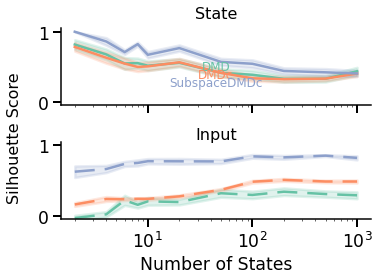

In [ ]:
methods = ['DMD','DMDc','Subspace DMDc']
#on two plots, plot the mean and std of the silhouette scores for each method across p_out / n
p_frac = np.array(n_uses[:len(silh_state_dmdcs)])

fig, ax = plt.subplots(2, 1, figsize=(5,4),sharex=True)

# Plot state silhouette scores

for i, state in enumerate([silh_state_dsas,silh_state_dmdcs,silh_state_subdmdcs]):
    ax[0].plot(p_frac, np.mean(state, axis=1), label=methods[i] + ' (State)',color=plt.cm.Set2(i))
    ax[0].fill_between(p_frac, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))

for i, state in enumerate([silh_ctrl_dsas,silh_ctrl_dmdcs,silh_ctrl_subsdmdcs]):
    ax[1].plot(p_frac, np.mean(state, axis=1), label=methods[i] + ' (Control)',color=plt.cm.Set2(i),linestyle='--')
    ax[1].fill_between(p_frac, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylim(-0.05,1.05)
ax[1].set_ylim(-0.05,1.05)
# Create custom legend with colored text
from matplotlib.lines import Line2D
ax[0].text(0.5, 0.5, 'DMD', color=plt.cm.Set2(0), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)
ax[0].text(0.5, 0.4, 'DMDc', color=plt.cm.Set2(1), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)
ax[0].text(0.5, 0.3, 'SubspaceDMDc', color=plt.cm.Set2(2), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)

# Add subplot titles
ax[0].set_title('State', fontsize=16, pad=10)
ax[1].set_title('Input', fontsize=16, pad=3)
ax[1].set_xlabel('Number of States')
fig.text(-0.05, 0.5, 'Silhouette Score', va='center', rotation='vertical',fontsize=16)
plt.tight_layout()


In [33]:
rs = np.arange(2,25,1)
n_iters = 2
silh_state_dmdcs = []
silh_ctrl_dmdcs = []
silh_state_subdmdcs = []
silh_ctrl_subsdmdcs = []
silh_state_dsas = []
silh_ctrl_dsas = []

for r in rs:
    silh_state_dmdc, silh_ctrl_dmdc, silh_state_subdmdc, silh_ctrl_subsdmdc, silh_state_dsa, silh_ctrl_dsa = get_silhouette_scores(n,m,p_out_small,
                                                                                                                N_small,n_iters,input_alpha=input_alpha,g1=g1,
                                                                                                                g2=g2,same_inp=False,n_Us=n_Us,n_delays=n_delays,rank=r,pf=pf,
                                                                                                              obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps,
                                                                                                              backend=backend)
    silh_state_dmdcs.append(silh_state_dmdc)
    silh_ctrl_dmdcs.append(silh_ctrl_dmdc)
    silh_state_subdmdcs.append(silh_state_subdmdc)
    silh_ctrl_subsdmdcs.append(silh_ctrl_subsdmdc)
    silh_state_dsas.append(silh_state_dsa)
    silh_ctrl_dsas.append(silh_ctrl_dsa)


  0%|          | 0/2 [00:02<?, ?it/s]


TypeError: get_subspace_dmdcs() got an unexpected keyword argument 'f'

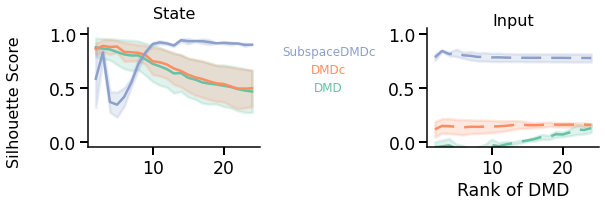

In [ ]:
methods = ['DMD','DMDc','Subspace DMDc']
#on two plots, plot the mean and std of the silhouette scores for each method across p_out / n

fig, ax = plt.subplots(1,2, figsize=(8,3),sharex=True)

# Plot state silhouette scores

for i, state in enumerate([silh_state_dsas,silh_state_dmdcs,silh_state_subdmdcs]):
    ax[0].plot(rs, np.mean(state, axis=1), label=methods[i] + ' (State)',color=plt.cm.Set2(i))
    ax[0].fill_between(rs, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))

for i, state in enumerate([silh_ctrl_dsas,silh_ctrl_dmdcs,silh_ctrl_subsdmdcs]):
    ax[1].plot(rs, np.mean(state, axis=1), label=methods[i] + ' (Control)',color=plt.cm.Set2(i),linestyle='--')
    ax[1].fill_between(rs, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))

# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
ax[0].set_ylim(-0.05,1.05)
ax[1].set_ylim(-0.05,1.05)
# Create custom legend with colored text
from matplotlib.lines import Line2D
ax[0].text(1.4, 0.8, 'SubspaceDMDc', color=plt.cm.Set2(2), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)
ax[0].text(1.4, 0.65, 'DMDc', color=plt.cm.Set2(1), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)
ax[0].text(1.4, 0.5, 'DMD', color=plt.cm.Set2(0), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)

# Add subplot titles
ax[0].set_title('State', fontsize=16, pad=10)
ax[1].set_title('Input', fontsize=16, pad=3)
ax[1].set_xlabel('Rank of DMD')
fig.text(-0.05, 0.5, 'Silhouette Score', va='center', rotation='vertical',fontsize=16)
plt.tight_layout()


In [ ]:
#varying eps and observing changes

nonlinear_eps_range = np.arange(0.1,1.1,0.1)
n_iters_local = 2  # override for this analysis

Y_feature_map = lambda x: x #np.concatenate([x,x**3,x**5],axis=0)
U_feature_map = lambda x: x

silh_state_dmdcs = []
silh_ctrl_dmdcs = []
silh_state_subdmdcs = []
silh_ctrl_subsdmdcs = []
silh_state_dsas = []
silh_ctrl_dsas = []

for i, nonlinear_eps in enumerate(nonlinear_eps_range):
    print(nonlinear_eps)
    ss_dmdc, sc_dmdc, ss_subdmdc, sc_subdmdc, ss_dsa, sc_dsa = get_silhouette_scores(n,m,p_out,
                                                                        N,n_iters_local,input_alpha=input_alpha,g1=g1,
                                                                        g2=g2,same_inp=False,n_Us=n_Us,n_delays=n_delays,rank=20,pf=200,
                                                                        nonlinear_eps=nonlinear_eps,nonlinear_func= lambda x: np.tanh(x),
                                                                        y_feature_map = Y_feature_map, u_feature_map = U_feature_map)
    silh_state_dmdcs.append(ss_dmdc)
    silh_ctrl_dmdcs.append(sc_dmdc)
    silh_state_subdmdcs.append(ss_subdmdc)
    silh_ctrl_subsdmdcs.append(sc_subdmdc)
    silh_state_dsas.append(ss_dsa)
    silh_ctrl_dsas.append(sc_dsa)

    print(np.mean(silh_state_dmdcs),np.mean(silh_state_subdmdcs),np.mean(silh_state_dsas))
    print()


silh_state_dmdcs = np.array(silh_state_dmdcs)
silh_state_subdmdcs = np.array(silh_state_subdmdcs)
silh_state_dsas = np.array(silh_state_dsas)
silh_ctrl_dmdcs = np.array(silh_ctrl_dmdcs)
silh_ctrl_subdmdcs = np.array(silh_ctrl_subsdmdcs)
silh_ctrl_dsas = np.array(silh_ctrl_dsas)



0.1


  0%|          | 0/2 [00:15<?, ?it/s]


KeyboardInterrupt: 

> /Users/mitchellostrow/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/linalg/linalg.py(952)qr()
    950     signature = 'D->D' if isComplexType(t) else 'd->d'
    951     extobj = get_linalg_error_extobj(_raise_linalgerror_qr)
--> 952     tau = gufunc(a, signature=signature, extobj=extobj)
    953 
    954     # handle modes that don't return q



/Users/mitchellostrow/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


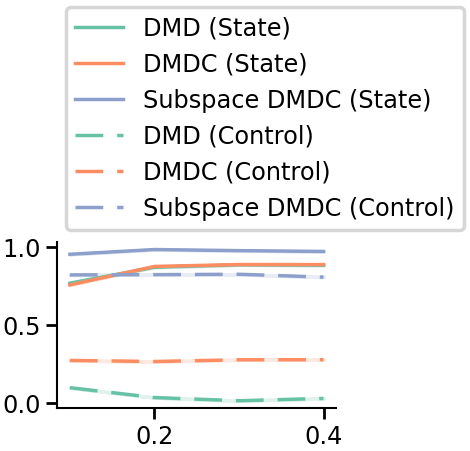

In [ ]:
#on two plots, plot the mean and std of the silhouette scores for each method across p_out / n
methods = [ 'DMD','DMDC', 'Subspace DMDC']

non_eps = nonlinear_eps_range[:len(silh_state_dmdcs)]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot state silhouette scores

for i, state in enumerate([silh_state_dsas,silh_state_dmdcs,silh_state_subdmdcs]):
    ax.plot(non_eps, np.mean(state, axis=1), label=methods[i] + ' (State)',color=plt.cm.Set2(i))
    ax.fill_between(non_eps, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))

for i, state in enumerate([silh_ctrl_dsas,silh_ctrl_dmdcs,silh_ctrl_subsdmdcs]):
    ax.plot(non_eps, np.mean(state, axis=1), label=methods[i] + ' (Control)',color=plt.cm.Set2(i),linestyle='--')
    ax.fill_between(non_eps, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))


ax.legend(loc='lower right',bbox_to_anchor=(1.5, 1))
